#CNN을 문자에도 사용
https://arxiv.org/abs/1408.5882 + 사진 cnn-for-sentence
- X batch, embedding layer 통과 5차원으로
- feature map = output of a filter
- kernel size 2씩 stride -> 6개 (대응되는 것 곱해서 출력) 곱해서 더하니까 5 -> 1
- kernel size 3씩 stride -> 5개 (대응되는 것 곱해서 출력)
- kernel size 4씩 stride -> 4개 (대응되는 것 곱해서 출력)
global max pooling
- 전체에선 max 값 -> concat  -> dense: 2개

- Sequential로 해결이 안되서 subclassing기법을 사용해야 함

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import os
import json
os.environ['KMP_DUPLICATE_LIB_OK'] = "TRUE"

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
DATA_IN_PATH = './data-in/'
DATA_OUT_PATH = './data-out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'nsmc_data_configs.json'

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [5]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [6]:
model_name = 'cnn_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1] #0 sample 수, 1 feature 수

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}

In [7]:
prepro_configs['vocab_size']

43756

In [8]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size']+1,
                                     output_dim=kargs['embedding_size'])  #128 압축 d=128 (밀집벡터) 
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'], #100
                                   kernel_size=kernel_size, #3, 4, 5
                                   padding='valid', #default 유효한 영역만 출력, 출력의 사이즈는 입력 보다 작음, ‘same’ : 출력 이미지 사이즈가 입력 이미지 사이즈와 동일
                                   activation='relu',
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.)) #가중치가 너무 커지면 불안정해질까봐 누름
                                      #MaxNorm(max_value=3.) 커널의 가중치값이 최대 값 3을 넘지 않게 설정
                         for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D() #전체에서 max값 하나
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'], #Positive integer, dimensionality of the output space. 250
                           activation='relu',
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.)) #max_value=max norm value for the incoming weights, #kernel_constraint= Constraint function applied to the kernel weights matrix 
        self.fc2 = layers.Dense(units=kargs['output_dimension'], #Positive integer, dimensionality of the output space. 1
                           activation='sigmoid', 
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x) #(43756+1) * 128
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1) #axis=-1가장 마지막 차원 기준으로 붙이기 #(128*3)*100+ 100, (128*4)*100+100, (128*5)*100+100
        #( axis=0, axis=1, axis=2)와 ( axis=-3, axis=-2 , axis =-1 ) 같은 의미
        x = self.fc1(x) # 300*250+250
        x = self.fc2(x) # 250*1+1
        
        return x

In [9]:
model = CNNClassifier(**kargs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
model.build((BATCH_SIZE, prepro_configs['vocab_size'] + 1))
model.summary()

Model: "cnn_classifier_kr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  5600896   
                                                                 
 conv1d (Conv1D)             multiple                  38500     
                                                                 
 conv1d_1 (Conv1D)           multiple                  51300     
                                                                 
 conv1d_2 (Conv1D)           multiple                  64100     
                                                                 
 global_max_pooling1d (Globa  multiple                 0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           multiple                  0         
                                                 

In [11]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True) #최대만,가중치만 저장

./data-out/cnn_classifier_kr -- Folder already exists 



- subclassing은 model.summary()는 model.fit 할때 만들어지기 때문에 불가능, 수동 model 만들어야 학습 전에 볼 수 있음
- Sequential() 로 layer 쌓으면 autobuild 되기 때문에 model.summary 불가능

In [12]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
264/264 [==============================] - ETA: 0s - loss: 0.4601 - accuracy: 0.7750
Epoch 1: val_accuracy improved from -inf to 0.82140, saving model to ./data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 22s 74ms/step - loss: 0.4601 - accuracy: 0.7750 - val_loss: 0.3937 - val_accuracy: 0.8214
Epoch 2/10
264/264 [==============================] - ETA: 0s - loss: 0.3515 - accuracy: 0.8461
Epoch 2: val_accuracy improved from 0.82140 to 0.82947, saving model to ./data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 19s 71ms/step - loss: 0.3515 - accuracy: 0.8461 - val_loss: 0.3829 - val_accuracy: 0.8295
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.3001 - accuracy: 0.8726
Epoch 3: val_accuracy did not improve from 0.82947
264/264 [==============================] - 17s 65ms/step - loss: 0.3001 - accuracy: 0.8726 - val_loss: 0.3961 - val_accuracy: 0.8227
Epoch 4/10
264/264 [=====================

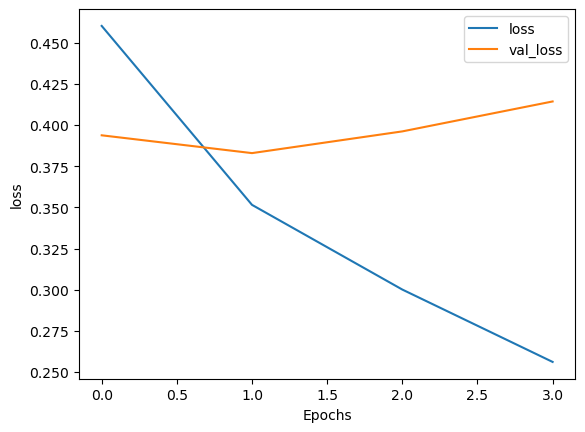

In [13]:
plot_graphs(history, 'loss')

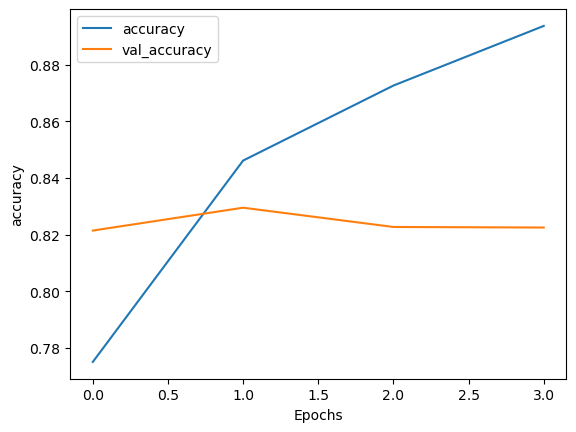

In [14]:
plot_graphs(history, 'accuracy')

In [16]:
DATA_OUT_PATH = './data-out/'
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5'

In [17]:
test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [18]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [19]:
model.evaluate(test_input, test_label_data)

1563/1563 [==============================] - 3s 2ms/step - loss: 0.3866 - accuracy: 0.8276


[0.38663381338119507, 0.8276000022888184]